In [1]:
pwd


'/content'

In [1]:
!git clone https://github.com/theschoolof-ai/JEDI.git

Cloning into 'JEDI'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 375 (delta 20), reused 9 (delta 2), pack-reused 332
Receiving objects: 100% (375/375), 240.58 MiB | 36.70 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [2]:
cd /content/JEDI/tsai.jedi

/content/JEDI/tsai.jedi


In [3]:
ls

aftereffects.py  dataloader.py         lr_finder.py    __pycache__/
batchnorm.py     datatransforms.py     main.py         README.md
cam.jpg          Engine_train_test.py  model_objects/
config.py        gradcam.py            Models/


In [4]:
import sys
sys.path.append('Models/')
from S8_resnet import ResNet18
from S7 import model_summary

In [5]:
import sys
sys.path.append('Models/')
from S7 import model_summary
from S9_resnet import resnet18

In [6]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 3.4MB/s 
     |████████████████████████████████| 952kB 10.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=ffcfb2295e04aa160588bd964f479a94da5e46d32ccdf084891fc4b57b24f3ba
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [7]:
sys.path.append(".")
%matplotlib inline
import torch
import config
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from Engine_train_test import train, test
# Cutout instroduced in train_loader_CIFAR10_alb
from dataloader import train_loader_CIFAR10_alb, test_loader_CIFAR10_alb
from aftereffects import get_image_with_target, plots
from lr_finder import LRFinder
import matplotlib.pyplot as plt
import torch.optim as optim
import sys
import config

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified



In [8]:
model_ = resnet18(num_classes = 10,pretrained = False).to(config.device)
print(model_summary(model_, config.input_size_CIFAR10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.23E-02


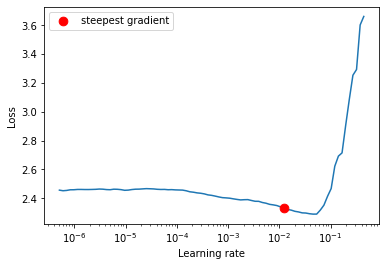

In [11]:

%matplotlib inline

import torch.nn as nn
import torch.optim as optim
from __future__ import print_function
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import sys

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


# SGD with momentum for lr_finder

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_.parameters(), lr=1e-7, momentum=0.9, weight_decay=5e-4)
lr_finder = LRFinder(model_, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader_CIFAR10_alb, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot()
lr_finder.reset()





In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
valid_acc = []
valid_loss = []
train_acc = []
train_loss = []
l1_regularization = [0, 0]

# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau

# Assign optimizer with suggested learning rate and run it with reduceonpleatue
optimizer = optim.SGD(model_.parameters(), lr=1.23E-02,  momentum=0.9, weight_decay=5e-4) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
for epoch in range(50):
    train_a, train_l = train(model_, config.device, train_loader_CIFAR10_alb, optimizer, epoch, l1_regularization=[0, 1])
    #scheduler.step()
    train_acc.append(train_a)
    train_loss.append(train_l)
    valid_a, valid_l = test(model_, config.device, test_loader_CIFAR10_alb)
    # Appending to loss and accuracy lists
    valid_acc.append(valid_a)
    valid_loss.append(valid_l)
    # Note that step should be called after validate()
    scheduler.step(valid_l)

Epoch: 0,LR: 0.0123.
Train set: train Average loss: 1.4300, train_Accuracy: 19512/50000 (39.0240%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 5217/10000 (52.1700%)



Epoch: 1,LR: 0.0123.
Train set: train Average loss: 1.1970, train_Accuracy: 27570/50000 (55.1400%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 6390/10000 (63.9000%)



Epoch: 2,LR: 0.0123.
Train set: train Average loss: 0.8817, train_Accuracy: 31548/50000 (63.0960%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 6932/10000 (69.3200%)



Epoch: 3,LR: 0.0123.
Train set: train Average loss: 0.7672, train_Accuracy: 34346/50000 (68.6920%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7035/10000 (70.3500%)



Epoch: 4,LR: 0.0123.
Train set: train Average loss: 0.7265, train_Accuracy: 36188/50000 (72.3760%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0065, Accuracy: 7315/10000 (73.1500%)



Epoch: 5,LR: 0.0123.
Train set: train Average loss: 0.6527, train_Accuracy: 37795/50000 (75.5900%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7965/10000 (79.6500%)



Epoch: 6,LR: 0.0123.
Train set: train Average loss: 0.7352, train_Accuracy: 38950/50000 (77.9000%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7514/10000 (75.1400%)



Epoch: 7,LR: 0.0123.
Train set: train Average loss: 0.7903, train_Accuracy: 39723/50000 (79.4460%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8118/10000 (81.1800%)



Epoch: 8,LR: 0.0123.
Train set: train Average loss: 0.4856, train_Accuracy: 40404/50000 (80.8080%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8205/10000 (82.0500%)



Epoch: 9,LR: 0.0123.
Train set: train Average loss: 0.4674, train_Accuracy: 41070/50000 (82.1400%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8024/10000 (80.2400%)



Epoch: 10,LR: 0.0123.
Train set: train Average loss: 0.4916, train_Accuracy: 41608/50000 (83.2160%)



loss=0.4354217052459717 batch_id=0:   0%|          | 1/391 [00:00<01:17,  5.06it/s]


Test set: Average loss: 0.0049, Accuracy: 7979/10000 (79.7900%)



Epoch: 11,LR: 0.0123.
Train set: train Average loss: 0.3509, train_Accuracy: 42140/50000 (84.2800%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8383/10000 (83.8300%)



Epoch: 12,LR: 0.0123.
Train set: train Average loss: 0.5942, train_Accuracy: 42674/50000 (85.3480%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8270/10000 (82.7000%)



Epoch: 13,LR: 0.0123.
Train set: train Average loss: 0.5143, train_Accuracy: 43039/50000 (86.0780%)



loss=0.2661783695220947 batch_id=0:   0%|          | 1/391 [00:00<01:17,  5.02it/s]


Test set: Average loss: 0.0041, Accuracy: 8400/10000 (84.0000%)



Epoch: 14,LR: 0.0123.
Train set: train Average loss: 0.4899, train_Accuracy: 43518/50000 (87.0360%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8293/10000 (82.9300%)



Epoch: 15,LR: 0.0123.
Train set: train Average loss: 0.6778, train_Accuracy: 43646/50000 (87.2920%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8298/10000 (82.9800%)



Epoch: 16,LR: 0.0123.
Train set: train Average loss: 0.3587, train_Accuracy: 43913/50000 (87.8260%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8461/10000 (84.6100%)



Epoch: 17,LR: 0.0123.
Train set: train Average loss: 0.4350, train_Accuracy: 44362/50000 (88.7240%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8484/10000 (84.8400%)



Epoch: 18,LR: 0.0123.
Train set: train Average loss: 0.3098, train_Accuracy: 44405/50000 (88.8100%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8598/10000 (85.9800%)



Epoch: 19,LR: 0.0123.
Train set: train Average loss: 0.3280, train_Accuracy: 44755/50000 (89.5100%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8430/10000 (84.3000%)



Epoch: 20,LR: 0.0123.
Train set: train Average loss: 0.2292, train_Accuracy: 44957/50000 (89.9140%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8662/10000 (86.6200%)



Epoch: 21,LR: 0.0123.
Train set: train Average loss: 0.2802, train_Accuracy: 45127/50000 (90.2540%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8653/10000 (86.5300%)



Epoch: 22,LR: 0.0123.
Train set: train Average loss: 0.2293, train_Accuracy: 45184/50000 (90.3680%)



loss=0.1481664925813675 batch_id=0:   0%|          | 1/391 [00:00<01:16,  5.12it/s]


Test set: Average loss: 0.0036, Accuracy: 8601/10000 (86.0100%)



Epoch: 23,LR: 0.0123.
Train set: train Average loss: 0.4084, train_Accuracy: 45558/50000 (91.1160%)



loss=0.24306580424308777 batch_id=0:   0%|          | 1/391 [00:00<01:16,  5.09it/s]


Test set: Average loss: 0.0036, Accuracy: 8627/10000 (86.2700%)



Epoch: 24,LR: 0.0123.
Train set: train Average loss: 0.2765, train_Accuracy: 45646/50000 (91.2920%)



loss=0.3212563991546631 batch_id=0:   0%|          | 1/391 [00:00<01:17,  5.05it/s]


Test set: Average loss: 0.0035, Accuracy: 8626/10000 (86.2600%)



Epoch: 25,LR: 0.0123.
Train set: train Average loss: 0.2602, train_Accuracy: 45721/50000 (91.4420%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8604/10000 (86.0400%)



Epoch: 26,LR: 0.0123.
Train set: train Average loss: 0.3043, train_Accuracy: 45832/50000 (91.6640%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8451/10000 (84.5100%)



Epoch: 27,LR: 0.0123.
Train set: train Average loss: 0.2481, train_Accuracy: 45908/50000 (91.8160%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8678/10000 (86.7800%)



Epoch: 28,LR: 0.0123.
Train set: train Average loss: 0.1161, train_Accuracy: 46142/50000 (92.2840%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8685/10000 (86.8500%)



Epoch: 29,LR: 0.0123.
Train set: train Average loss: 0.2925, train_Accuracy: 46086/50000 (92.1720%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8640/10000 (86.4000%)



Epoch: 30,LR: 0.0123.
Train set: train Average loss: 0.1525, train_Accuracy: 46283/50000 (92.5660%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8670/10000 (86.7000%)



Epoch: 31,LR: 0.0123.
Train set: train Average loss: 0.2481, train_Accuracy: 46431/50000 (92.8620%)



loss=0.19942139089107513 batch_id=0:   0%|          | 1/391 [00:00<01:17,  5.05it/s]


Test set: Average loss: 0.0033, Accuracy: 8738/10000 (87.3800%)



Epoch: 32,LR: 0.0012300000000000002.
Train set: train Average loss: 0.1283, train_Accuracy: 47588/50000 (95.1760%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8993/10000 (89.9300%)



Epoch: 33,LR: 0.0012300000000000002.
Train set: train Average loss: 0.1155, train_Accuracy: 48141/50000 (96.2820%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 9006/10000 (90.0600%)



Epoch: 34,LR: 0.0012300000000000002.
Train set: train Average loss: 0.1399, train_Accuracy: 48337/50000 (96.6740%)



loss=0.13688604533672333 batch_id=0:   0%|          | 1/391 [00:00<01:17,  5.03it/s]


Test set: Average loss: 0.0025, Accuracy: 9014/10000 (90.1400%)



Epoch: 35,LR: 0.0012300000000000002.
Train set: train Average loss: 0.0735, train_Accuracy: 48375/50000 (96.7500%)



loss=0.14879591763019562 batch_id=0:   0%|          | 1/391 [00:00<01:17,  5.02it/s]


Test set: Average loss: 0.0025, Accuracy: 9021/10000 (90.2100%)



Epoch: 36,LR: 0.0012300000000000002.
Train set: train Average loss: 0.0352, train_Accuracy: 48432/50000 (96.8640%)



loss=0.11421504616737366 batch_id=0:   0%|          | 1/391 [00:00<01:17,  5.04it/s]


Test set: Average loss: 0.0025, Accuracy: 9034/10000 (90.3400%)



Epoch: 37,LR: 0.0012300000000000002.
Train set: train Average loss: 0.0789, train_Accuracy: 48539/50000 (97.0780%)



loss=0.1426384150981903 batch_id=0:   0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9024/10000 (90.2400%)



Epoch: 38,LR: 0.0012300000000000002.
Train set: train Average loss: 0.0653, train_Accuracy: 48583/50000 (97.1660%)



loss=0.06845608353614807 batch_id=0:   0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9021/10000 (90.2100%)



Epoch: 39,LR: 0.0012300000000000002.
Train set: train Average loss: 0.2049, train_Accuracy: 48650/50000 (97.3000%)



loss=0.06238362565636635 batch_id=0:   0%|          | 1/391 [00:00<01:17,  5.05it/s]


Test set: Average loss: 0.0025, Accuracy: 9049/10000 (90.4900%)



Epoch: 40,LR: 0.0012300000000000002.
Train set: train Average loss: 0.0818, train_Accuracy: 48661/50000 (97.3220%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9045/10000 (90.4500%)



Epoch: 41,LR: 0.0012300000000000002.
Train set: train Average loss: 0.1603, train_Accuracy: 48726/50000 (97.4520%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9081/10000 (90.8100%)



Epoch: 42,LR: 0.0012300000000000002.
Train set: train Average loss: 0.0486, train_Accuracy: 48723/50000 (97.4460%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9067/10000 (90.6700%)



Epoch: 43,LR: 0.0012300000000000002.
Train set: train Average loss: 0.1150, train_Accuracy: 48770/50000 (97.5400%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9058/10000 (90.5800%)



Epoch: 44,LR: 0.0012300000000000002.
Train set: train Average loss: 0.0524, train_Accuracy: 48770/50000 (97.5400%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9055/10000 (90.5500%)



Epoch: 45,LR: 0.0012300000000000002.
Train set: train Average loss: 0.0579, train_Accuracy: 48829/50000 (97.6580%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9068/10000 (90.6800%)



Epoch: 46,LR: 0.0012300000000000002.
Train set: train Average loss: 0.0299, train_Accuracy: 48804/50000 (97.6080%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9045/10000 (90.4500%)



Epoch: 47,LR: 0.0012300000000000002.
Train set: train Average loss: 0.0645, train_Accuracy: 48888/50000 (97.7760%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9036/10000 (90.3600%)



Epoch: 48,LR: 0.0012300000000000002.
Train set: train Average loss: 0.0383, train_Accuracy: 48896/50000 (97.7920%)



  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 9049/10000 (90.4900%)



Epoch: 49,LR: 0.0012300000000000002.
Train set: train Average loss: 0.1066, train_Accuracy: 48881/50000 (97.7620%)


Test set: Average loss: 0.0025, Accuracy: 9043/10000 (90.4300%)



In [11]:
# Save the model
torch.save(model_, '/content/JEDI/tsai.jedi/model_objects/s10_resnet_albu_cutout_lrfinder_v1.pt')
#torch.save(model_, 'JEDI/tsai.jedi/model_objects/s10.pt')

### Train Vs Validation Plots

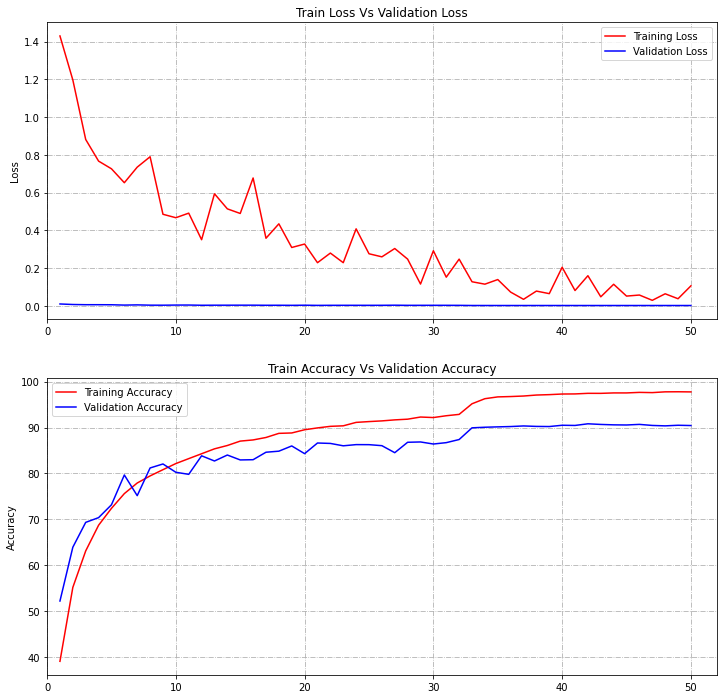

In [12]:
# 
import matplotlib.pyplot as plt
epoch = 50
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, epoch+2])
plt.ylabel('Loss')
plt.title('Train Loss Vs Validation Loss')
plt.plot(range(1, epoch+1), train_loss[:epoch+1], 'r', label='Training Loss')
plt.plot(range(1, epoch+1), valid_loss[:epoch+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)

ax = plt.gca()
ax.set_xlim([0, epoch+2])
plt.ylabel('Accuracy')
plt.title('Train Accuracy Vs Validation Accuracy')
plt.plot(range(1, epoch+1), train_acc[:epoch+1], 'r', label='Training Accuracy')
plt.plot(range(1, epoch+1), valid_acc[:epoch+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()

In [13]:
from dataloader import classes_CIFAR10
path = '/content/JEDI/tsai.jedi/model_objects/s10_resnet_albu_cutout_lrfinder_v1.pt'
data_t,target_t,pred_t,data_,target_,pred_ = get_image_with_target(model_path=path, number_of_img=25, dataloader=test_loader_CIFAR10_alb,
                                              is_classified = False,return_torch = 'Both')
title = ['target:' + classes_CIFAR10[i] + '\n' + 'pred:' + classes_CIFAR10[j] for i, j in zip(target_, pred_)]


In [14]:

data_t = data_t.permute(0,3,1,2)
data_t.shape,target_t.shape

(torch.Size([25, 3, 32, 32]), torch.Size([25]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

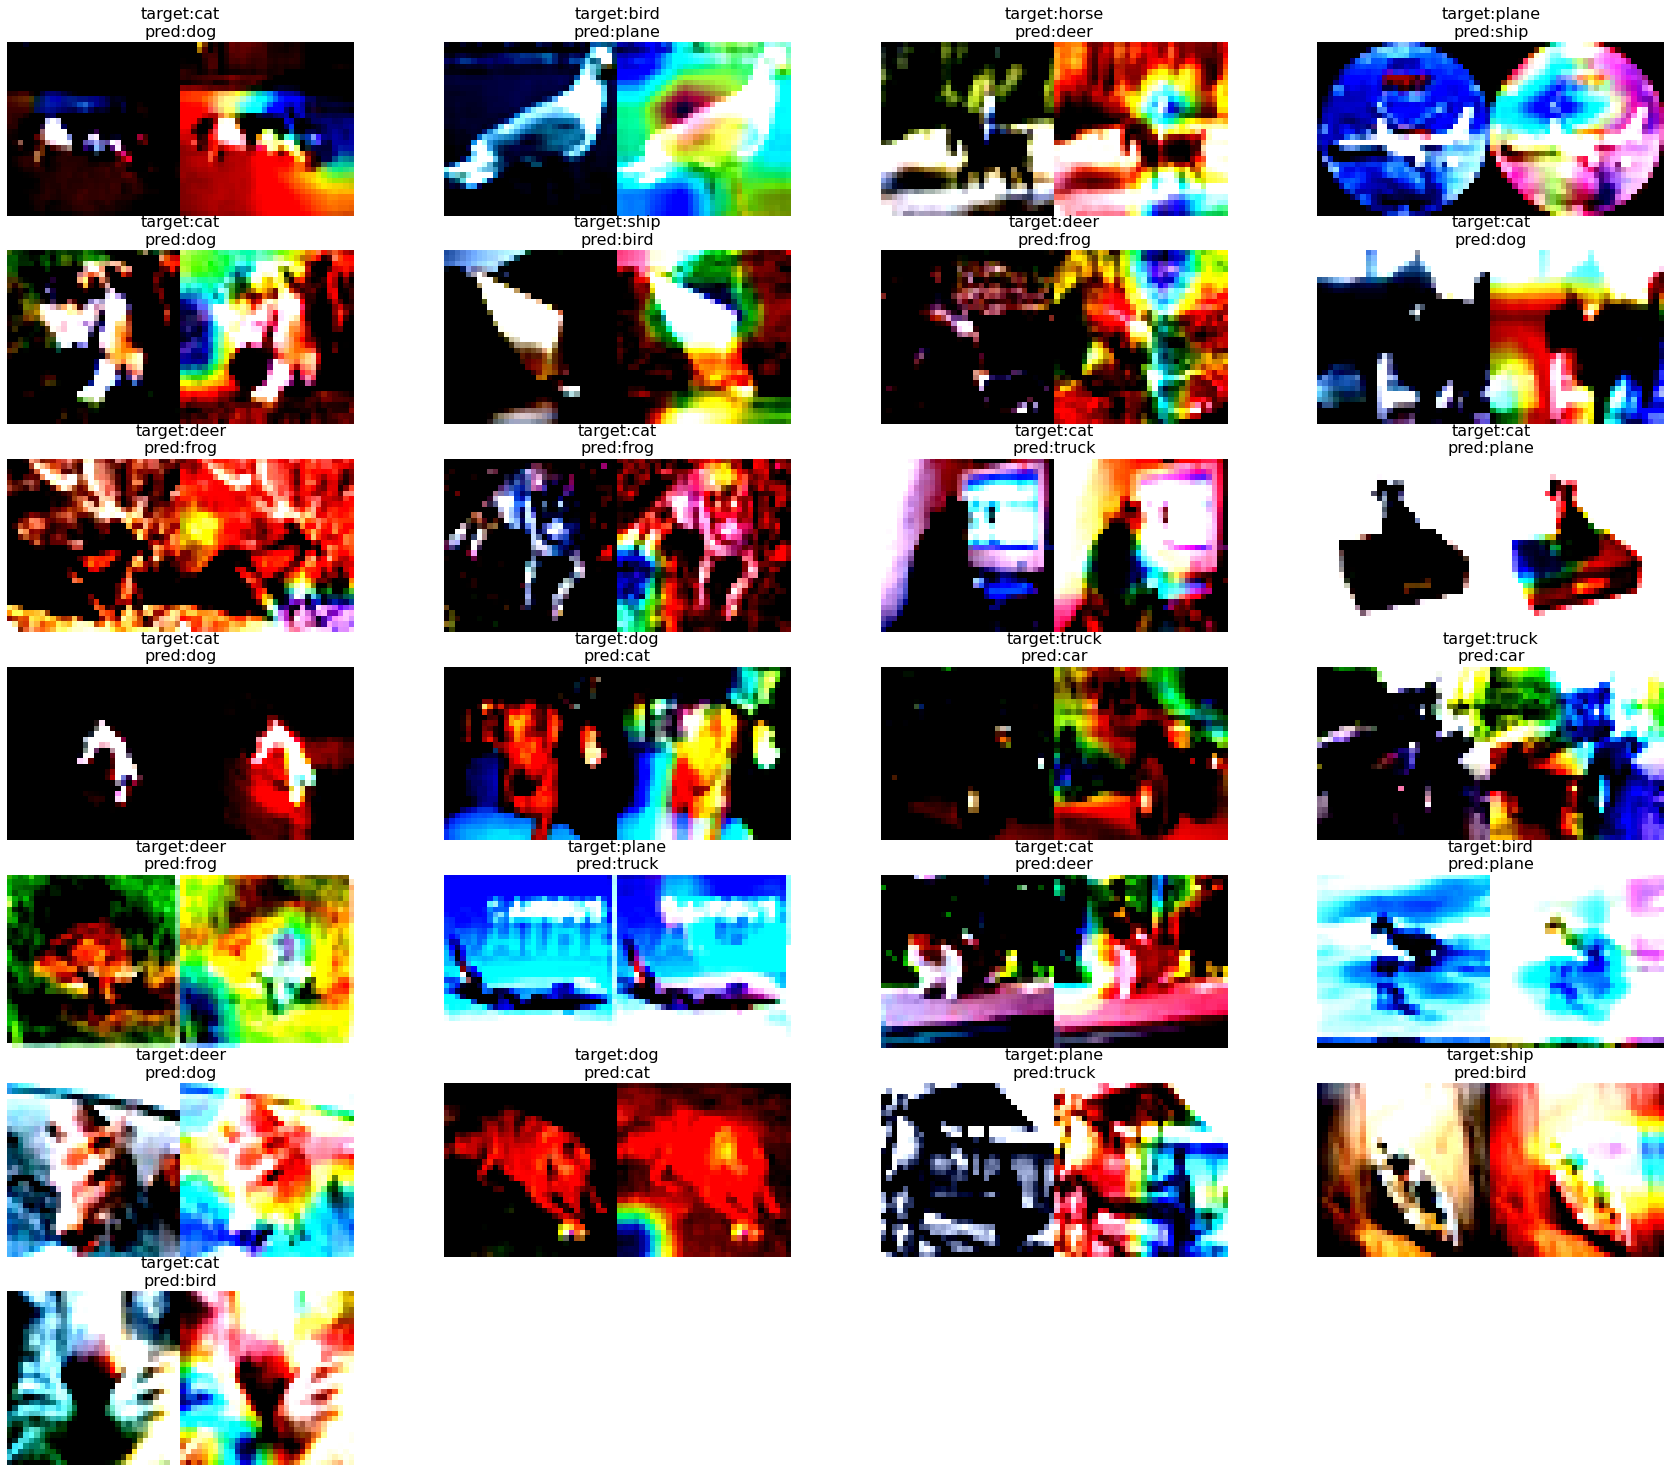

In [15]:
import torch
model = torch.load(path)
import config
from gradcam import GradCam
from gradcam import show_cam_on_image
gradcam_img = []
for idx in range(len(data_t)): 
    ip = data_t.index_select(0,torch.tensor(idx))
    grad_cam = GradCam(model=model, feature_module=model.layer3,target_layer_names=["1"], use_cuda=config.use_cuda)
    mask = grad_cam(ip)
    op_img = show_cam_on_image(ip.squeeze().permute(1,2,0), mask)
    gradcam_img.append(op_img)
plots(gradcam_img,titles=title, rows = 8,figsize = (30,30))